In [1]:
%matplotlib inline
import numpy as np
import rydsim
from pylab import*
import matplotlib.pyplot as plt
from qutip import *
import qutip
import scipy
import random

# Calculating timings 

In [2]:
J = 3e6        #interactions
t = 12e-9     #timing after pulse

f = J*(6*t)
print('WHH4      tc: ',6*t/1e-9,'ns t: ', t/1e-9, 'ns Percentage: ',f)
t_1 = 10e-9
f_1 = J*(24*t_1)
print('Treversal tc: ',24*t/1e-9,'ns t: ', t_1/1e-9, 'ns Percentage: ',f_1)

WHH4      tc:  71.99999999999999 ns t:  12.0 ns Percentage:  0.216
Treversal tc:  287.99999999999994 ns t:  10.0 ns Percentage:  0.7200000000000001


# Define Hamiltonian

In [81]:
def dipolar_ham(N, Jx, Jy, Jz, psi0, tlist, gamma, solver):

    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

    # construct the hamiltonian
    H = 0
    

    # interaction terms
    J = 3
    
    for n in range(N-1):
        H +=  J * Jx[n] * sx_list[n] * sx_list[n+1]
        H +=  J * Jy[n] * sy_list[n] * sy_list[n+1]
        H +=  J * Jz[n] * sz_list[n] * sz_list[n+1]

   
    # collapse operators
    c_op_list = []

    # spin dephasing
    for n in range(N):
        if gamma[n] > 0.0:
            c_op_list.append(np.sqrt(gamma[n]) * sz_list[n])

    # evolve and calculate expectation values
    if solver == "me":
        result = mesolve(H, psi0, tlist, c_op_list ,options=Options(nsteps=1e10))
    elif solver == "mc":
        ntraj = 250 
        result = mcsolve(H, psi0, tlist, c_op_list, sz_list, ntraj)

    return result.states, H , sz_list, sy_list

def pulse_ham(N, h, Jx, Jy, Jz, phi, psi0, gamma, solver):

    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

    # construct the hamiltonian
    H = 0
    
    # energy splitting terms
    for n in range(N):
        H +=  0.5 * h[n] * (np.cos(phi) * sx_list[n] + np.sin(phi) * sy_list[n])

    # interaction terms
    J = 3
    
    for n in range(N-1):
        H +=  J * Jx[n] * sx_list[n] * sx_list[n+1]
        H +=  J * Jy[n] * sy_list[n] * sy_list[n+1]
        H +=  J * Jz[n] * sz_list[n] * sz_list[n+1]

    #tlist
    
    tlist = linspace(0, 1*np.pi/(2 * h[0]), 90)
    
    # collapse operators
    c_op_list = []

    # spin dephasing
    for n in range(N):
        if gamma[n] > 0.0:
            c_op_list.append(np.sqrt(gamma[n]) * sz_list[n])

    # evolve and calculate expectation values
    if solver == "me":
        result = mesolve(H, psi0, tlist, c_op_list ,options=Options(nsteps=1e10))
    elif solver == "mc":
        ntraj = 250 
        result = mcsolve(H, psi0, tlist, c_op_list, sz_list, ntraj)

    return result.states, tlist

# Initial conditions

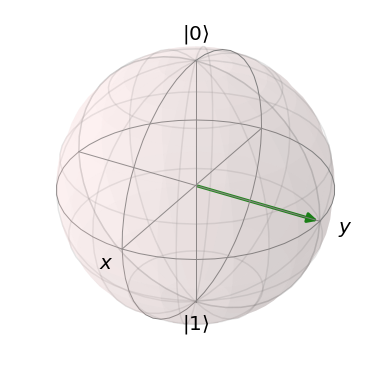

In [106]:
# set up the calculation
#
solver = "me"   # use the ode solver
#solver = "mc"   # use the monte-carlo solver

N = 10           # number of spins
t = 0.002      #time between pulses in mu seconds
step = 500      #timespacings

tau = linspace(0, t, step)
tau_2 = linspace(0, 2*t, 2*step)



# dephasing rate
gamma = 0.0 * np.ones(N)

# intial state: all x
psi_list = []
for n in range(N):
    psi_list.append(1/sqrt(2) * (basis(2,0)+1j*basis(2,1)))
    
psi0 = tensor(psi_list)

#plot initial state of atom 1
b = Bloch()
a = psi0
state_i = a.ptrace(0)
b.add_states(state_i)
b.show()

# First pulses

In [92]:
#1
phi = 0
h  = 0 * 2 * np.pi * np.ones(N) 
Jz = 2 * 2 * np.pi * np.ones(N)
Jx = -1 * 2 * np.pi * np.ones(N)
Jy = -1 * 2 * np.pi * np.ones(N)

state_1 , H, sz_list , sy_list = dipolar_ham(N, Jx, Jy, Jz, psi0, tau, gamma, solver)

In [93]:
#2
Jz = -1 * 2 * np.pi * np.ones(N)
Jx = -1 * 2 * np.pi * np.ones(N)
Jy = 2 * 2 * np.pi * np.ones(N)

psi_2 = state_1[-1]
state_2 , H, sz_list , sy_list = dipolar_ham(N, Jx, Jy, Jz, psi_2, tau, gamma, solver)

In [94]:
#3
Jz = -1 * 2 * np.pi * np.ones(N)
Jx = 2 * 2 * np.pi * np.ones(N)
Jy = -1 * 2 * np.pi * np.ones(N)

psi_3 = state_2[-1]
state_3 , H, sz_list , sy_list = dipolar_ham(N, Jx, Jy, Jz, psi_3, tau_2, gamma, solver)

In [95]:
#4
Jz = -1 * 2 * np.pi * np.ones(N)
Jx = -1 * 2 * np.pi * np.ones(N)
Jy = 2 * 2 * np.pi * np.ones(N)

psi_4 = state_3[-1]
state_4 , H, sz_list , sy_list = dipolar_ham(N, Jx, Jy, Jz, psi_4, tau, gamma, solver)

In [96]:
#5
Jz = 2 * 2 * np.pi * np.ones(N)
Jx = -1 * 2 * np.pi * np.ones(N)
Jy = -1 * 2 * np.pi * np.ones(N)

psi_5 = state_4[-1]
state_5 , H, sz_list , sy_list = dipolar_ham(N, Jx, Jy, Jz, psi_5, tau, gamma, solver)

In [97]:
psi_init = state_1[0]
psi_final = state_5[-1]
fid = fidelity(psi_init, psi_final)
print('Fidelity = ', fid)


Fidelity =  0.9999163679180872


#  Apply pulses

In [110]:
#1
phi = 0
hh = 1000
h  = hh * 2 * np.pi * np.ones(N) 
Jz = 2 * 2 * np.pi * np.ones(N)
Jx = -1 * 2 * np.pi * np.ones(N)
Jy = -1 * 2 * np.pi * np.ones(N)

#1

state_a , Hdip, sz_list , sy_list = dipolar_ham(N, Jx, Jy, Jz, psi0, tau, gamma, solver)
state_b ,tlistt = pulse_ham(N, h, Jx, Jy, Jz, phi, state_a[-1], gamma, solver)

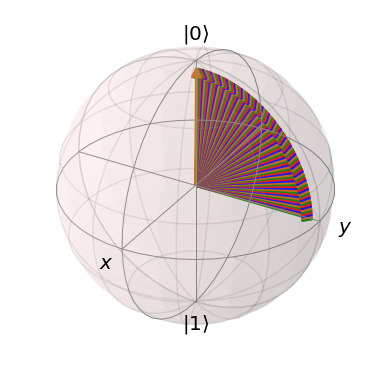

In [87]:
b = Bloch()
for i in range(len(tlistt)):
    a = state_b[i]
    state_i = a.ptrace(0)
    b.add_states(state_i)
b.show()

In [111]:
#2
phi = np.pi/2
h  = -hh * 2 * np.pi * np.ones(N)

state_c , Hdip, sz_list , sy_list = dipolar_ham(N, Jx, Jy, Jz, state_b[-1], tau, gamma, solver)
state_d, tlistt = pulse_ham(N, h, Jx, Jy, Jz, phi, state_c[-1], gamma, solver)

In [112]:
#3
phi = np.pi/2
h  = hh * 2 * np.pi * np.ones(N)

state_e , Hdip, sz_list , sy_list = dipolar_ham(N, Jx, Jy, Jz, state_d[-1], tau_2, gamma, solver)
state_f, tlistt = pulse_ham(N, h, Jx, Jy, Jz, phi, state_e[-1], gamma, solver)

In [113]:
#4
phi = 0
h  = -hh * 2 * np.pi * np.ones(N)

state_g , Hdip, sz_list , sy_list = dipolar_ham(N, Jx, Jy, Jz, state_f[-1], tau, gamma, solver)
state_h, tlistt = pulse_ham(N, h, Jx, Jy, Jz, phi, state_g[-1], gamma, solver)

In [114]:
#5
state_end , Hdip, sz_list , sy_list = dipolar_ham(N, Jx, Jy, Jz, state_h[-1], tau, gamma, solver)

In [115]:
psi_init = state_a[0]
psi_final = state_end[-1]
fid = fidelity(psi_init, psi_final)
print('Fidelity = ', fid)


Fidelity =  0.9980965242751629
